In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

# Q1)  Work electric field form infinitessimally thin spherical shell of charge with radius R. Use both integrator and scipy.integrate.quad to plot the electric field from the shell as a function of distance from the centre of the sphere. Make sure the range of your plot covers regions with $z<R, z>R$, and one your $z$-values is $R$. Is there a singularity in the integral? Does quad care? Your integrator? 

We need to first find the integrand which we can then pass to our own integrator and quad to evaluate. We can set this problem up using by orienting E in the $z$-direction which is aligned with the centre of our spherical shell, where $dq = \sigma da = \sigma R^2 sin\theta d\theta d\phi$, where we have assumed a spherical coordinate system. Therefore our integral becomes;

\begin{equation}
E_z = \frac{1}{4\pi \epsilon_0} \int \frac{\sigma R^2 sin\theta d\theta d\phi (z-Rcos\theta)}{(R^2 + z^2 - 2 R z cos\theta)^{3/2}} \,\,\,\, \text{for} \,\,\,\, r^2 = R^2 + z^2 - 2 R z cos\theta
\end{equation}

and $r$ is the distance from the centre of the sphere. We need to over integrate $\phi, \theta$ over $[0,2\pi], [0,\pi]$ respectively to obtain the integral as a function of z. The $\phi$ integral is straightforward given there is no $\phi$-dependence in the integrand, and hence, we just get a factor of $2\pi$ out front. Therefore, we can pass the integrand,

\begin{equation}
dE = \frac{1}{2 \epsilon_0} \frac{\sigma R^2 sin\theta d\theta (z-Rcos\theta)}{(R^2 + z^2 - 2 R z cos\theta)^{3/2}}, \,\,\,\, \text{for} \,\,\,\, \sigma = \text{constant}
\end{equation}

to our own/quad integrator and integrate over $\theta$. 

In [ ]:
# Define integrand as function of theta, ignoring constants, set R = sigma = 1

R, eps, sigma = 1, 1, 1

def dE(theta, z):
    return sigma*(R**2 * np.sin(theta) * (z - R*np.cos(theta)))/(2*eps*(R**2 + z**2 - 2*R*z*np.cos(theta))**(3/2))

# First use scipy.integrate.quad, need to solve integral for range of z-values

def quad_integrate(integrand, bounds, z_arr):
    integral_z = []
    a, b = bounds[0], bounds[1] # lower and upper bounds of integral
    for z in z_arr:
        integral_z.append(scipy.integrate.quad(integrand, a, b, args=(z))[0]) # integral at each z-value
    return integral_z                                      

In [ ]:
# Simpsons rule integrator from class modified to take z as input in function

def integrator(fun,x0,x1,tol,z):
    x=np.linspace(x0,x1,5)
    y=fun(x, z)
    dx=(x1-x0)/(len(x)-1)
    area1=2*dx*(y[0]+4*y[2]+y[4])/3 #coarse step
    area2=dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3 #finer step
    err=np.abs(area1-area2)
    if err<tol:
        return area2
    else:
        xmid=(x0+x1)/2
        left=integrator(fun,x0,xmid,tol/2,z)
        right=integrator(fun,xmid,x1,tol/2,z)
        return left+right

In [ ]:
# Now plot quad integrator results versus own integrator

z_range = np.linspace(0.5,1.5,101) # linspace of z-values, spanning from inside of sphere to outside
quad_integrate_dE = quad_integrate(dE, [0,np.pi], z_range)

simpsons_integrate_dE = []
for z in z_range:
    if z==1.0: # encounter a singularity here, so just set the point to zero, other recursive failure
        simpsons_integrate_dE.append(0)
        continue
    simpsons_integrate_dE.append(integrator(dE, 0, np.pi, 1e-6, z)) # integrate using integrator from class 


fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(z_range, quad_integrate_dE, '*', label='Quad Integrator')
ax.plot(z_range, simpsons_integrate_dE, '*', label = 'Simpsons Integrator')
ax.set_xlabel('z', fontsize=16)
ax.set_ylabel('E(z)', fontsize=16)
ax.set_title('Comparison of Quad and Recursive Integrator', fontsize=16)
ax.legend(fontsize=16);

Clearly, as noted above there is a singularity at $z=1$ (where $z=R$), which the Simpson's adaptive integrator could not handle, and had to be adjusted for that case (just set the field value to zero). However, the quad integrator was able to handle this case fine, as we see the point in the graph it plotted at $z=1$. Analytically however, this singularity disappears - although given we are integrating the integrand numerically, our integrators are forced to deal with the singularity.

# Q2) Write a recursive step size integrator like the one we wrote in class that does NOT call $f(x)$ multiple times for the same $x$. Include $extra$ as an input that contains the information a sub-call needs from preceding calls. On the initial call $extra=\texttt{None}$. For a few typical examples, how many function calls do you save vs. the lazy way we wrote it in class. 

In [ ]:
# Function we defined in class, added counter to tally number of function evals

def lazy_integrate_adaptive(fun,x0,x1,tol):
    #hardwire to use simpsons
    x=np.linspace(x0,x1,5)
    y=fun(x)
    f_evals = len(x)
    dx=(x1-x0)/(len(x)-1)
    area1=2*dx*(y[0]+4*y[2]+y[4])/3 #coarse step
    area2=dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3 #finer step
    err=np.abs(area1-area2)
    if err<tol:
        return area2, f_evals
    else:
        xmid=(x0+x1)/2
        left, f_eval_left =lazy_integrate_adaptive(fun,x0,xmid,tol/2)
        right, f_eval_right =lazy_integrate_adaptive(fun,xmid,x1,tol/2)
        f_evals += f_eval_left+f_eval_right
        return left+right, f_evals

In [ ]:
def integrate_adaptive(fun, a, b, tol, extra=None):
    
    '''
    Recursive variable step size integrator that only calls f(x) once for each x.
    fun: function
        function to integrate
    a: float
        lower bound
    b: float
        upper bound
    tol: float
        if integral error exceeds tol, subdivide the interval of integration in two and apply adaptive 
        Simpson's method to each subinterval in a recursive manner
    extra: None or list-type
        contains previous function evaluations to be passed to subsequent recursions
    '''
    
    if extra is None: # only occurs for the first iteration, following outline of lazy_integrate_adaptive
        dx = (b-a)/4 
        x = np.linspace(a,b,5)
        y = fun(x)
        f_evals = len(x) # number of function evals
        
    else:
        dx = (b-a)/4
        y1,y3 = fun(a+dx), fun(a+3*dx) # new function evaluations (left, right)
        f_evals = 2 # 2 function evals per recursion
        y = [extra[0], y1, extra[1], y3, extra[2]] # list of all our function evaluations for current recursion
        
    area1 = 2*dx*(y[0]+4*y[2]+y[4])/3 # coarse step
    area2 = dx*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3 # finer step
    delta = np.abs(area2-area1)

    if delta<tol: # if condition met, recursion is over
        return area2, f_evals
    else:
        m = (a+b)/2 # divide interval of integration in two, tolerance too, pass function evals in extra
        fl, f_evals_l = integrate_adaptive(fun, a, m, tol/2.0, extra=[y[0], y[1], y[2]])
        fr, f_evals_r = integrate_adaptive(fun, m, b, tol/2.0, extra=[y[2], y[3], y[4]])
        f_tot, f_evals = fl+fr, f_evals_l+f_evals_r
        return f_tot, f_evals

In [ ]:
# Test out the integrator on sample functions --> sin(x), x**5, exp(x)

def poly(x):
    return x**5

f_integ_adapt_sin, f_evals_integ_adapt_sin = integrate_adaptive(np.sin, 0, 4, 1e-8)
f_lazy_sin, f_evals_lazy_sin = lazy_integrate_adaptive(np.sin, 0, 4, 1e-8)
f_integ_adapt_poly, f_evals_integ_adapt_poly = integrate_adaptive(poly, 0, 1, 1e-6)
f_lazy_poly, f_evals_lazy_poly = lazy_integrate_adaptive(poly, 0, 1, 1e-6)
f_integ_adapt_exp, f_evals_integ_adapt_exp = integrate_adaptive(np.exp, -1, 1, 1e-9)
f_lazy_exp, f_evals_lazy_exp = lazy_integrate_adaptive(np.exp, -1, 1, 1e-9)

print('Number of Evaluations for function: sin(x)')
print('Adaptive Integrator (One f(x) per x): ', f_evals_integ_adapt_sin)
print('Lazy Adaptive Integrator: ', f_evals_lazy_sin, '\n')
print('Number of Evaluations for function: x**5')
print('Adaptive Integrator (One f(x) per x): ', f_evals_integ_adapt_poly)
print('Lazy Adaptive Integrator: ', f_evals_lazy_poly, '\n')
print('Number of Evaluations for function: exp(x)')
print('Adaptive Integrator (One f(x) per x): ', f_evals_integ_adapt_exp)
print('Lazy Adaptive Integrator: ', f_evals_lazy_exp)

Therefore, on average there are roughly $20\%$ of the function evaluations performed when using our adaptive integrator that stores previous function evaluations versus the simple one we wrote in class that does not. 

# Q3) Write a function that models the log base 2 of x valid from 0.5 to 1 to an accuracy in the region better than $10^{-6}$. Use truncated Chebyshev polynomial fit to do this - np.polynomial.chebyshev.chebfit, how many terms do you need? (Use many x/y values and fit to some higher order, then only keep terms you think you'll need and drop rest, make sure to rescale the x-range before going from -1 to 1 before challing chebfit)

To meet the accuracy criterion of $10^{-6}$ we can simply filter the Chebyshev polynomial coefficients that are larger (absolute magnitude) than this value, given smaller coefficients will not influence this accuracy threshold (due to decreasing coefficient magnitude with order).

In [2]:
def trunc_chebyshev_log2(x, degree, tol=1e-6): 
    
    '''
    Function to return the best fit Chebyshev polynomial of smallest order (and its order) 
    to log2(x) between [0.5, 1] satisfying an accuracy tolerance of 1e-6.
    
    x: array-like
        array of evenly-spaced values from [0.5, 1]
    
    degree: int
        order of Chebyshev polynomial to fit before truncation
    
    tol: float
        minimum accuracy of truncated Chebyshev polynomial, default = 1e-6
    '''

    # We need to rescale the x values to be between -1 and 1 first
    x_new = x - np.min(x)
    x_new = x_new/np.max(x_new)
    x_new = 2*x_new - 1
    
    # Now evaluate log2(x)
    y = np.log2(x)
    
    # Now fit the data using numpy chebfit and evaluate residuals
    cheb_coef = np.polynomial.chebyshev.chebfit(x_new, y, degree) # get chebyshev coefficients for each degree
    trunc_cheb_coef = cheb_coef[np.abs(cheb_coef) > 1e-6] # truncate using criterion that coefs > 1e-6 stay
    
    # evaluate chebyshev poly with coeffs
    trunc_cheb_val = np.polynomial.chebyshev.chebval(x_new, trunc_cheb_coef)
    trunc_terms = len(trunc_cheb_coef) # degree of truncated chebyshev polynomial
    
    return trunc_cheb_val, trunc_cheb_coef, trunc_terms
    

Chebyshev polynomial terms required to obtain accuracy > 1e-6: 8


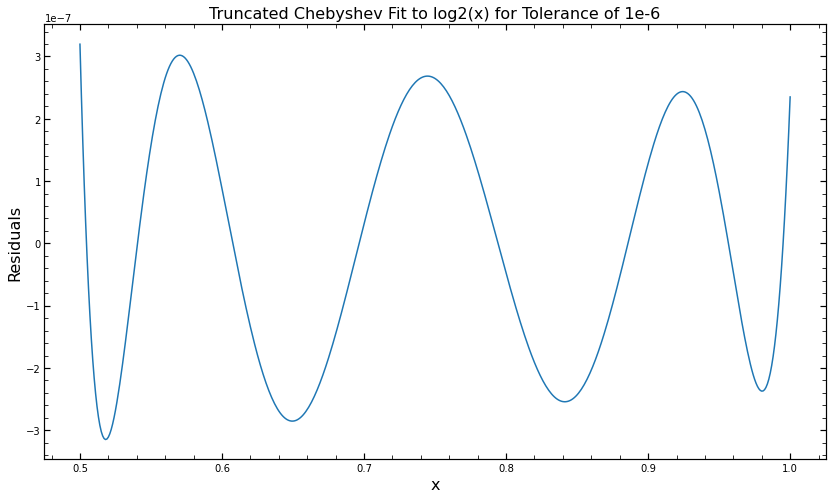

In [3]:
# Test out truncation function

npt = 501
xx = np.linspace(0.5, 1.0, npt)
yy = np.log2(xx)
trunc_cheb_fit, trunc_cheb_coefs, trunc_cheb_terms = trunc_chebyshev_log2(xx, 15) # evaluated for degree = 15

fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(xx, trunc_cheb_fit - yy)
ax.set_ylabel('Residuals', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_title('Truncated Chebyshev Fit to log2(x) for Tolerance of 1e-6', fontsize=16)
print('Chebyshev polynomial terms required to obtain accuracy > 1e-6: ' + repr(trunc_cheb_terms));

Therefore, the number of terms required are 8 implying a Chebyshev polynomial of degree 7 is needed to meet the accuracy threshold. 

We can use the decomposition of an array of numbers into their mantissa and exponent and subsequently fit $log2(x)$ using our previously defined function, and simply use the resulting chebyshev polynomial to then evaluate log2(x) using the mantissa and add back the exponent to obtain the best fitting data given $log_2(x) = \text{exponent} + log_2(\text{mantissa})$. From here, to evaluate the natural logarithm, we use the fact that $log_n(x) = \frac{log_m(x)}{log_m(n)}$, so we can calculate the natural logarithm of $x$ by dividing $log2(x)/log2(e)$. 

In [33]:
def mylog2(x, degree):
    
    '''
    Function to evaluate the natural log of any positive number. Use same tolerance/accuracy
    in the truncated Chebyshev polynomial fit.
    
    x:
        value to evaluate the natural log at.
    degree:
        order of Chebyshev polynomial to fit to the log2(x).
    '''
    x_fit = np.linspace(0.5, 1, 1001) # define linspace to fit over, always (0.5, 1)
    trunc_cheb_fit, trunc_cheb_coef, trunc_terms = trunc_chebyshev_log2(x_fit, degree)  # fit log_2(x_fit)
   
    mantissa_x, exp_x = np.frexp(x) # Need to first decompose x into mantissa, exponent; x = mantissa*2**exp
    mantissa_e, exp_e = np.frexp(np.e)
    scaled_mantissa_x = np.interp(mantissa_x, (0.5, 1), (-1, 1)) # scale for chebval
    scaled_mantissa_e = np.interp(mantissa_e, (0.5, 1), (-1, 1))
    
    # now evaluate log2(mantissa) using Chebyshev coefficients and add to exponent to get log2(x)
    trunc_cheb_fit_log2x = np.polynomial.chebyshev.chebval(scaled_mantissa_x, trunc_cheb_coef) + exp_x
    trunc_cheb_fit_log2e = np.polynomial.chebyshev.chebval(scaled_mantissa_e, trunc_cheb_coef) + exp_e
    trunc_cheb_fit_lnx = (trunc_cheb_fit_log2x)/trunc_cheb_fit_log2e # now evaluate our ln fit
    
    return trunc_cheb_fit_lnx, trunc_terms

Chebyshev polynomial terms required to obtain accuracy > 1e-6: 8


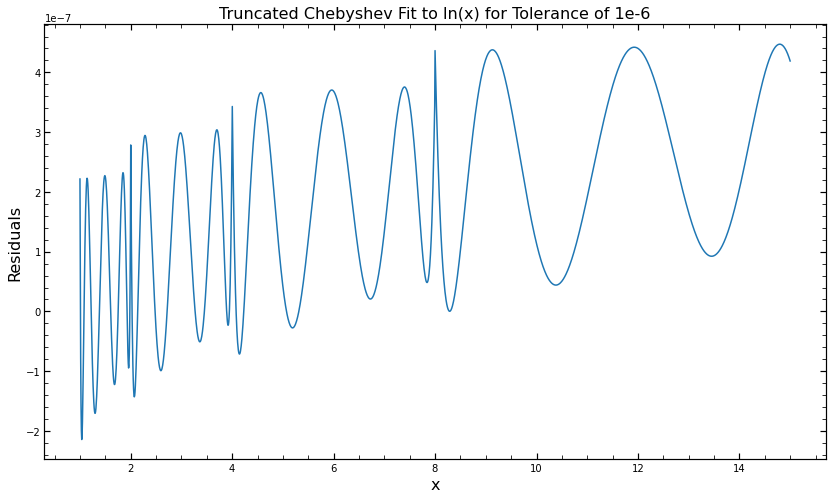

In [36]:
# Test out mylog2 to see how well it fits the natural logarithm data over a large x range

npt1 = 2001
x1 = np.linspace(1, 15.0, npt1)
y1 = np.log(x1)
trunc_cheb_fit_ln, trunc_terms1 =  mylog2(x1, 15) # set degree = 15

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(x1, trunc_cheb_fit_ln - y1)
ax.set_ylabel('Residuals', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_title('Truncated Chebyshev Fit to ln(x) for Tolerance of 1e-6', fontsize=16)
print('Chebyshev polynomial terms required to obtain accuracy > 1e-6: ' + repr(trunc_terms1));

Clearly we see again the residuals are less than 1e-6 given the truncation criterion in trunc_chebyshev_log2. 